In [1]:
!pip install tensorflow

#Importing the Libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset


In [3]:
# Load dataset
file_path = "/content/fake reviews dataset (1).csv"
df = pd.read_csv(file_path)

In [4]:
# Text Cleaning Function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())  # Remove special chars, convert to lowercase
    return text

df['text_'] = df['text_'].apply(clean_text)

#VISUALIZATION

In [5]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,love this well made sturdy and very comfortab...
1,Home_and_Kitchen_5,5.0,CG,love it a great upgrade from the original ive...
2,Home_and_Kitchen_5,5.0,CG,this pillow saved my back i love the look and ...
3,Home_and_Kitchen_5,1.0,CG,missing information on how to use it but it is...
4,Home_and_Kitchen_5,5.0,CG,very nice set good quality we have had the set...


In [6]:
df.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
df.columns

Index(['category', 'rating', 'label', 'text_'], dtype='object')

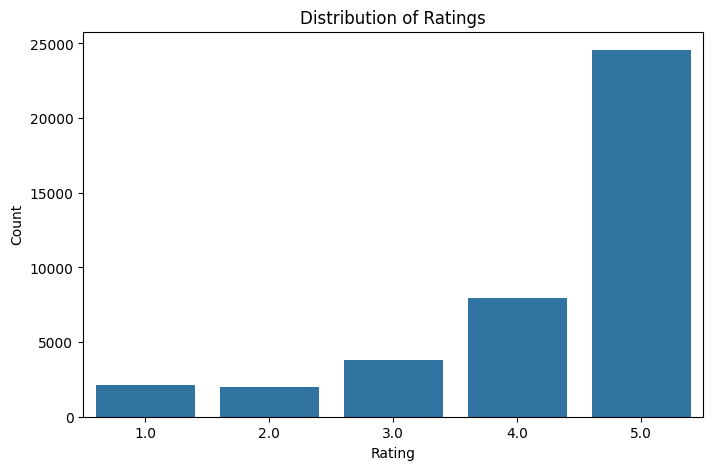

In [9]:
# 1. Distribution of Ratings
plt.figure(figsize=(8,5))
sns.countplot(x=df['rating'])
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Inference: Most reviews tend to cluster around 5 ratings, indicating possible trends in user feedback.

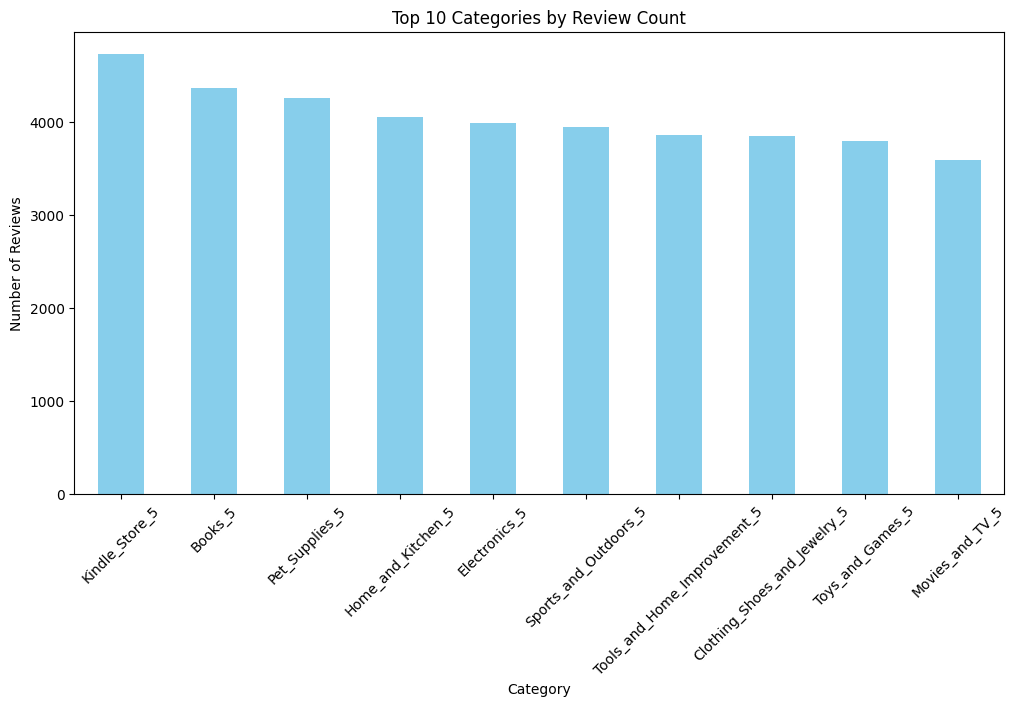

In [10]:
# 2. Category-wise Review Count
plt.figure(figsize=(12,6))
df['category'].value_counts().nlargest(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Categories by Review Count")
plt.xlabel("Category")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()

# Inference: Kindle_store_5 product categories receive more reviews than others, highlighting their popularity.

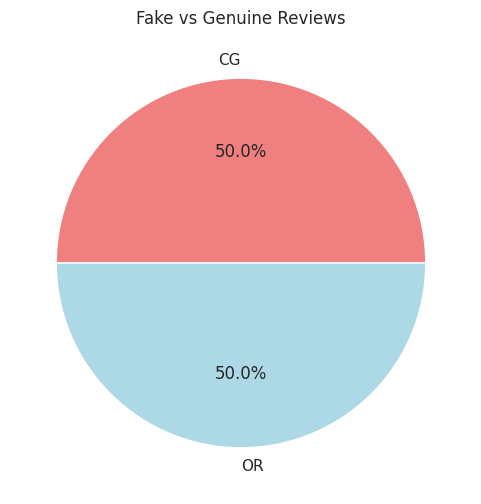

In [11]:
# Set seaborn style
sns.set(style="whitegrid")
# 3. Label Distribution (Fake vs Genuine Reviews)
plt.figure(figsize=(6,6))
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title("Fake vs Genuine Reviews")
plt.ylabel("")
plt.show()

# Inference: The proportion of fake reviews compared to genuine reviews are same.

In [12]:
# Print the sum of missing values for each column
print("Missing Values")
print(df.isnull().sum())

Missing Values
category    0
rating      0
label       0
text_       0
dtype: int64


In [13]:
# Preprocessing
X = df['text_'].astype(str).values
y = df['label'].values

In [14]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization and Padding for LSTM
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

# LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train, epochs=3, batch_size=32, validation_data=(X_test_pad, y_test))

print("Training finished!")


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 219s 211ms/step - accuracy: 0.6411 - loss: 0.6123 - val_accuracy: 0.8610 - val_loss: 0.3226
Epoch 2/3
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 212s 209ms/step - accuracy: 0.8997 - loss: 0.2568 - val_accuracy: 0.9300 - val_loss: 0.1884
Epoch 3/3
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 266s 213ms/step - accuracy: 0.9402 - loss: 0.1607 - val_accuracy: 0.9355 - val_loss: 0.1734
Training finished!


In [15]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"LSTM Model Accuracy: {accuracy * 100:.2f}%")


253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9370 - loss: 0.1667
LSTM Model Accuracy: 93.55%


In [17]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump((tokenizer, model), f)

In [18]:
# Sample input
sample_text = "Fridge working good but gasket problem."

# Preprocess: tokenize and pad
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_pad = pad_sequences(sample_seq, maxlen=100, padding='post')

# Predict
prediction = model.predict(sample_pad)
label = (prediction > 0.5).astype("int32")

# Decode label
decoded_label = label_encoder.inverse_transform(label.flatten())

print(f"Prediction: {prediction[0][0]:.4f}")
print(f"Predicted label: {decoded_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
Prediction: 0.7419
Predicted label: OR
